# Modulos

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import xarray as xr 
import rioxarray
import geopandas as geo
from shapely.geometry import mapping
import cdsapi
import glob
import os
import numpy as np
import pytz
import rasterio as rio 


# Tratamiendo Netcf

## merge, hour ajust, clip

In [8]:
folders=['2m temperature','Soil temperature level 1','Skin temperature','Surface net solar radiation','Total evaporation','Total precipitation','Volumetric soil water layer 1',]
x=folders[2]
path='D:/user/Desktop/IA en Geo/Datos/Eras5/'+x+ '/*.nc'       
files=list(map(lambda x:x.replace('\\','/'),glob.glob(path)))
nc=xr.open_mfdataset(files,combine='by_coords')
# nc_clip=nc.sel(longitude=slice(-72, -66.5), latitude=slice(7.3,1.8))
nc_clip=nc
nc_clip_time=nc_clip.sel(time=slice('2015-01-01T05:00:00', '2019-12-31T05:00:00'))
nc_clip_time_day=nc_clip_time.resample(time='D').mean()
# mask.shp
geodf = geo.read_file('D:/user/Desktop/IA en Geo/Shapes/Region orinoquia/vichada.shp')
# coordinates
nc_clip_time_day_crs=nc_clip_time_day.rio.write_crs("epsg:4326")
#netcdf clipped
clipped = nc_clip_time_day_crs.rio.clip(geodf.geometry.apply(mapping), geodf.crs)  
clipped_drop=clipped.drop_vars('spatial_ref')   
# export 
clipped_drop.to_netcdf('D:/user/Desktop/IA en Geo/Datos/Eras5/Netcdf final/'+x+'total.nc')
    # return(clipped_drop)
# nc=netcdf(folders[0])
# nc_clip_time_day
clipped_drop


<xarray.Dataset>
Dimensions:    (longitude: 36, latitude: 36, time: 1826)
Coordinates:
  * longitude  (longitude) float32 -71.0 -70.9 -70.8 -70.7 ... -67.7 -67.6 -67.5
  * latitude   (latitude) float32 6.3 6.2 6.1 6.0 5.9 ... 3.2 3.1 3.0 2.9 2.8
  * time       (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2019-12-31
Data variables:
    skt        (time, latitude, longitude) float32 dask.array<chunksize=(1826, 36, 36), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2022-11-08 01:10:59 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...

# Mapas

## slope

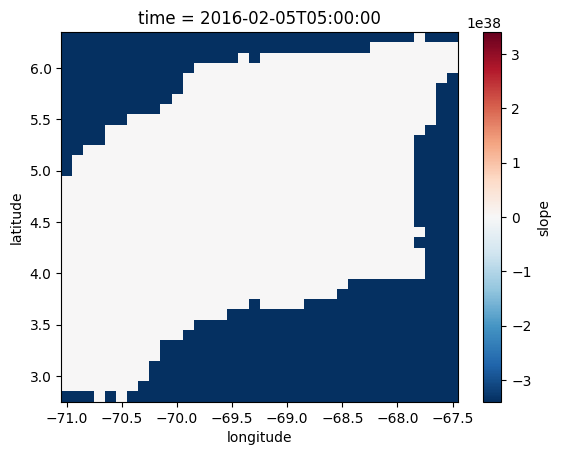

In [3]:
path='D:/user/Desktop/IA en Geo/Shapes/slope/slop.tif'

tif= rioxarray.open_rasterio(path)
times=pd.date_range(start='2015-01-01T05:00:00', end='2019-12-31T05:00:00')
tif=tif.rename(new_name_or_name_dict={"x":'longitude',"y": 'latitude'})
tif=tif.drop_vars('spatial_ref')
tif=tif.drop_vars('band')      
tif=tif.expand_dims(dim={"time": times})
dataset=tif.to_dataset( name='slope')
# dataset.to_netcdf('D:/user/Desktop/IA en Geo/Shapes/slope/slop.nc')
dataset.slope[400].plot()


## Cover


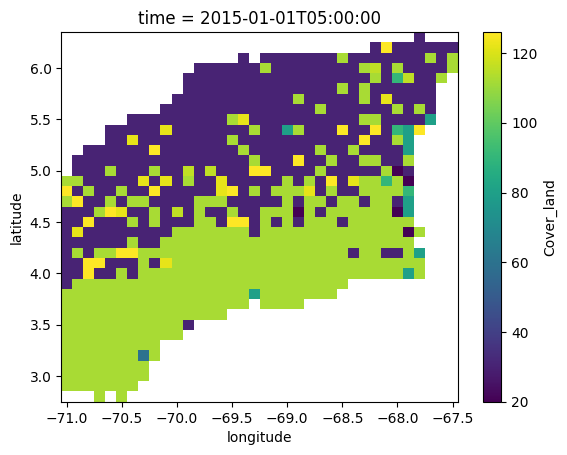

In [12]:
def cover():
    folders=['Coberturas/Final_cov']
    x=folders[0]
    path='D:/user/Desktop/IA en Geo/Shapes/'+x+ '/*.tif'
    files=list(map(lambda x:x.replace('\\','/'),glob.glob(path)))
    # for i in range (5):
    tif= rioxarray.open_rasterio(files[4])
    times=pd.date_range(start='2019-01-01T05:00:00', end='2019-12-31T05:00:00')
    tif=tif.rename(new_name_or_name_dict={"x":'longitude',"y": 'latitude'})
    tif=tif.drop_vars('spatial_ref')
    tif=tif.drop_vars('band')      
    tif=tif.expand_dims(dim={"time": times})
    dataset=tif.to_dataset( name='Cover_land')
    return(dataset)

#group
# def group():
path='D:/user/Desktop/IA en Geo/Shapes/Coberturas/Nc/Cover.nc'       
files=list(map(lambda x:x.replace('\\','/'),glob.glob(path)))
nc=xr.open_mfdataset(files,combine='by_coords')
    # nc.to_netcdf('D:/user/Desktop/IA en Geo/Shapes/Coberturas/Nc/Cover.nc')
    # dataset.to_netcdf('D:/user/Desktop/IA en Geo/Shapes/Coberturas/Nc/2019.nc')
nc.Cover_land[0].plot()

# Independent variable

### Radiation

In [5]:
path='D:/user/Desktop/IA en Geo/Datos/Eras5/Netcdf final/Surface net solar radiationtotal.nc'
ssr=xr.open_dataset(path)
ssr_arr=ssr.ssr.values
ssr_vect=ssr_arr.ravel()
ssr_vect.shape

(2366496,)

### Precipitation

In [6]:
path='D:/user/Desktop/IA en Geo/Datos/Eras5/Netcdf final/Total precipitationtotal.nc'
tp=xr.open_dataset(path)
# tp_arr=tp.tp.values
# tp_vect=tp_arr.ravel()
# tp_vect.shape
tp

<xarray.Dataset>
Dimensions:    (longitude: 36, latitude: 36, time: 1826)
Coordinates:
  * longitude  (longitude) float32 -71.0 -70.9 -70.8 -70.7 ... -67.7 -67.6 -67.5
  * latitude   (latitude) float32 6.3 6.2 6.1 6.0 5.9 ... 3.2 3.1 3.0 2.9 2.8
  * time       (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2019-12-31
Data variables:
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-10-07 17:03:30 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

### Evaporation

In [7]:
path='D:/user/Desktop/IA en Geo/Datos/Eras5/Netcdf final/Total evaporationtotal.nc'
e=xr.open_dataset(path)
e_arr=e.e.values
e_vect=e_arr.ravel()
e_vect.shape

(2366496,)

### Water soil

In [8]:
path='D:/user/Desktop/IA en Geo/Datos/Eras5/Netcdf final/Volumetric soil water layer 1total.nc'
swvl1=xr.open_dataset(path)
swvll1_arr=swvl1.swvl1.values
swvll1_vect=swvll1_arr.ravel()
swvll1_vect.shape

(2366496,)

### Cover

In [9]:
path='D:/user/Desktop/IA en Geo/Shapes/Coberturas/Nc/Cover.nc'
cover=xr.open_dataset(path)
cov_arr=cover.Cover_land.values
cov_vect=cov_arr.ravel()
cov_vect.shape

(2366496,)

### Slope

In [10]:
path='D:/user/Desktop/IA en Geo/Shapes/slope/slop.nc'
slope=xr.open_dataset(path)
slope_arr=slope.slope.values
slope_vect=slope_arr.ravel()
slope_vect.shape

(2366496,)

# Dependent variable

In [11]:
gridx = np.arange(-71.0,-67.4, 0.1)
gridy = np.arange(6.3,2.7,-0.1)
path='D:/user/Desktop/IA en Geo/Datos/co2/adaptor.mars_constrained.internal-1667789622.839241-14092-6-e2ed9d7d-c0cb-46de-85ca-08d9dab0f316.nc'
nc=xr.open_dataset(path)
nc_grid =nc.reindex(longitude=gridx,latitude=gridy, method='nearest')
nc_grid_clip=nc_grid.sel(longitude=slice(-72, -66.5), latitude=slice(7.3,1.8))
# mask.shp
geodf = geo.read_file('D:/user/Desktop/IA en Geo/Shapes/Region orinoquia/vichada.shp')
# coordinates
nc_grid_clip_crs=nc_grid_clip.rio.write_crs("epsg:4326")
#netcdf clipped
clipped = nc_grid_clip_crs.rio.clip(geodf.geometry.apply(mapping), geodf.crs)
clipped_drop=clipped.drop_vars('spatial_ref')
# clipped_drop.to_netcdf('D:/user/Desktop/IA en Geo/Datos/co2/final.nc' )
# clipped.co2fire[100].plot()
clipped_drop

<xarray.Dataset>
Dimensions:    (longitude: 36, latitude: 36, time: 1826)
Coordinates:
  * longitude  (longitude) float64 -71.0 -70.9 -70.8 -70.7 ... -67.7 -67.6 -67.5
  * latitude   (latitude) float64 6.3 6.2 6.1 6.0 5.9 ... 3.2 3.1 3.0 2.9 2.8
  * time       (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2019-12-31
Data variables:
    co2fire    (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    Conventions:  CF-1.6
    history:      2022-11-07 03:06:46 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [12]:
path='D:/user/Desktop/IA en Geo/Datos/co2/final.nc'
co2=xr.open_dataset(path)
co2_arr=co2.co2fire.values
co2_vect=co2_arr.ravel()
co2_vect.shape

(2366496,)

In [13]:
# def netcdf(x):
gridx = np.arange(-71.0,-67.4, 0.1)
gridy = np.arange(6.3,2.7,-0.1)
path='D:/user/Desktop/IA en Geo/Datos/Fireburnedarea/*.nc'       
files=list(map(lambda x:x.replace('\\','/'),glob.glob(path)))
nc=xr.open_mfdataset(files,combine='by_coords')
nc_LC=nc.LC
nc_LC_clip=nc_LC.sel(lon=slice(-72, -66.5), lat=slice(7.3,1.8))
# # nc_clip_time=nc_clip.sel(time=slice('2015-01-01T05:00:00', '2019-12-31T05:00:00'))
# mask.shp
geodf = geo.read_file('D:/user/Desktop/IA en Geo/Shapes/Region orinoquia/vichada.shp')
# coordinates
nc_LC_clip_crs=nc_LC_clip.rio.write_crs("epsg:4326")
# #netcdf clipped
clipped = nc_LC_clip_crs.rio.clip(geodf.geometry.apply(mapping), geodf.crs)  
clipped_drop=clipped.drop_vars('spatial_ref')
clipped_grid = clipped_drop.reindex(lon=gridx, lat=gridy, method='nearest')
# # clipped_grid_Month=clipped_grid.resample(time='M').mean()
clipped_grid_day=clipped_grid.resample(time='D').max()
# clipped_grid_day.to_netcdf('D:/user/Desktop/IA en Geo/Datos/Fireburnedarea/Final/final.nc' )
clipped_grid_day
# clipped_grid_day[0].plot()

<xarray.DataArray 'LC' (time: 1827, lat: 36, lon: 36)>
dask.array<where, shape=(1827, 36, 36), dtype=float64, chunksize=(32, 36, 36), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -71.0 -70.9 -70.8 -70.7 ... -67.8 -67.7 -67.6 -67.5
  * lat      (lat) float64 6.3 6.2 6.1 6.0 5.9 5.8 ... 3.3 3.2 3.1 3.0 2.9 2.8
  * time     (time) datetime64[ns] 2014-12-01 2014-12-02 ... 2019-12-01
Attributes:
    long_name:  Land cover of burned pixels
    units:      Land cover code
    comment:    Land cover of the burned pixel, extracted from the CCI LandCo...

In [14]:
path='D:/user/Desktop/IA en Geo/Datos/Fireburnedarea/Final/final.nc' 
burn=xr.open_dataset(path)
burn_arr=burn.LC.values
burn_vect=burn_arr.ravel()
burn_vect.shape

(2367792,)